In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
retraining_epochs = 50

def retrain_layer(model_retrain, model_orig, data_loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, temp, loss_type = 'MSEL', data_size = 'search', savedir = ''):
    
    weight_loader = model_retrain.state_dict()
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_orig.state_dict()[layer]
    model_retrain.load_state_dict(weight_loader)

    exp_name = "{}_a{}_b{}_r{}_t{}_m{}_kdT{}_{}".format(model_retrain.name, alpha, beta, retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta), scaling = False)
    gmp.print_batch = False

    print ("Model Name: {}".format(model_retrain.name))
    criterion = nn.MSELoss()
    opt = torch.optim.Adam([
        {'params': model_retrain.parameters(), 'lr': 1e-4},
        {'params': [gmp.means], 'lr': 1e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

    
    for epoch in range(retraining_epochs):
        model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, opt, criterion, data_loader, tau, temp, loss_type)

        if (trueAfterN(epoch, 10)):
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            layer_accuracy(model_retrain, gmp, model_orig, test_data_full, test_labels_full)
            
    if(savedir!=""):
        torch.save(model_retrain, savedir + 'mnist_retrain_{}.m'.format(exp_name))
        with open(savedir + 'mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
            
    return model_retrain, gmp

def get_layer_data(target_dir, temp, layer, model_name, data_size):
    x_start = 0
    x_end = 60000
    if (data_size == "search"):
        x_start = 40000
        x_end = 50000
    if ("SWSModel" in model_name):
        if (layer == 1):
            layer_model = model_archs.SWSModelConv1().cuda()
            input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
            output = get_targets(target_dir, temp, ["conv1.out"])["conv1.out"][x_start:x_end]
        if (layer == 2):
            layer_model = model_archs.SWSModelConv2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["conv1.out"])["conv1.out"][x_start:x_end])
            output = (get_targets(target_dir, temp, ["conv2.out"])["conv2.out"][x_start:x_end])
        if (layer == 3):
            layer_model = model_archs.SWSModelFC1().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["conv2.out"])["conv2.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end]
        if (layer == 4):
            layer_model = model_archs.SWSModelFC2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end]

    if ("LeNet_300_100" in model_name):
        if (layer == 1):
            layer_model = model_archs.LeNet_300_100FC1().cuda()
            input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
            output = get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end]
        if (layer == 2):
            layer_model = model_archs.LeNet_300_100FC2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end])
            output = (get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end])
        if (layer == 3):
            layer_model = model_archs.LeNet_300_100FC3().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc3.out"])["fc3.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc3.out"])["fc3.out"][x_start:x_end]


    dataset = torch.utils.data.TensorDataset(input.data, output.data)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return layer_model, loader

def init_retrain_layer(alpha, beta, tau, temp, mixtures, model_name, data_size, layer, savedir = ""):
    test_data_full =  Variable(test_data(fetch = "data")).cuda()
    test_labels_full =  Variable(test_data(fetch = "labels")).cuda()
    val_data_full =  Variable(search_validation_data(fetch = "data")).cuda()
    val_labels_full =  Variable(search_validation_data(fetch = "labels")).cuda()

    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model_orig = torch.load(model_load_dir + model_file + '.m').cuda()

    layer_model, loader = get_layer_data(target_dir, temp, layer, model_name, data_size)

    model, gmp = retrain_layer(layer_model, model_orig, loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, temp, data_size, model_dir + model_file)
    return model, gmp

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:

mean = 20000
var = 2
zmean = 20000
zvar = 10
#means = get_init_means(8, 60, 9)
#print (means)
mixtures = 15
temp = 5
tau = 1e-8
def layer_exp(mean, var, zmean, zvar, mixtures, temp, tau, layer = 1, loss_type = 'MSEHA'):
    data_size = 'search'
    model_name = 'LeNet_300_100'

    beta = mean/var
    alpha = mean * beta
    ab = (alpha, beta)
    zbeta = zmean/zvar
    zalpha = zmean * zbeta
    zab = (zalpha, beta)
    
    #tau_scd = np.array(list(range(retraining_epochs))) - (retraining_epochs-1)/2
    #tau_scd = 5 * tau_scd/tau_scd.max()
    #tau_scd = (0.1 + 0.9 * (1.0/(1.0 + np.exp(tau_scd)))) * 1e-10

    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    full_model = torch.load(model_load_dir + model_file + ".m")

    (x_start, x_end) = (40000, 50000)
    if(layer == 1):
        layer_model = model_archs.LeNet_300_100FC1().cuda()
        input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
        output = (get_targets(model_file, 0, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
    if(layer == 2):
        layer_model = model_archs.LeNet_300_100FC2().cuda()
        input = (get_targets(model_file, 0, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
        input = nn.ReLU()(input)
        input = input/temp
        output = (get_targets(model_file, 0, ["fc2.out"])["fc2.out"][x_start:x_end]).cuda()
    if(layer == 3):
        layer_model = model_archs.LeNet_300_100FC3().cuda()
        input = (get_targets(model_file, 0, ["fc2.out"])["fc2.out"][x_start:x_end]).cuda()
        input = nn.ReLU()(input)
        input = input/temp
        output = (get_targets(model_file, 4, ["fc3.out"])["fc3.out"][x_start:x_end]).cuda()
    #output = (get_targets(model_file, temp, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
    
    ###ReLU Check
    if (loss_type == 'MSEHA' or loss_type =='CESH'):
        output = nn.ReLU()(output)
    if (loss_type == 'CESH'):
        output = nn.Softmax(dim=1)(output/temp)

    test_data_full = Variable(test_data(fetch = "data")).cuda()
    test_labels_full = Variable(test_data(fetch = "labels")).cuda()
    val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
    val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()

    dataset = torch.utils.data.TensorDataset(input.data, output.data)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    state_dict = copy.deepcopy(layer_model.state_dict())
    for layer in state_dict:
        state_dict[layer] = full_model.state_dict()[layer]
    layer_model.load_state_dict(state_dict)

    exp_name = "{}_a{}_za{}_r{}_t{}_m{}_kdT{}_{}".format(layer_model.name, ab[0], zab[0], retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in layer_model.parameters()], 0.99, zero_ab = (zalpha, zbeta), ab = (alpha, beta), scaling = False)
    gmp.print_batch = False
    criterion = nn.MSELoss()
    opt = torch.optim.Adam([
        {'params': layer_model.parameters(), 'lr': 1e-4},
        {'params': [gmp.means], 'lr': 3e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

    for epoch in range(50):
        #mean = mean_mult[epoch]
        #mean = 50000
        #beta = mean/var
        #alpha = mean * beta
        #gmp.ab = (alpha, beta)

        layer_model, loss = retrain_sws_epoch(layer_model, gmp, opt, criterion, loader, tau, temp, loss_type)

        if (trueAfterN(epoch, 25)):
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            show_sws_weights(model = layer_model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
            res = layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)
            
    res_test = layer_accuracy(layer_model, gmp, full_model, val_data_full, val_labels_full)
    res_val = layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)
    res = {}
    res['compress_test'] = res_test[0]
    res['compress_val'] = res_val[0]
    res['prune_test'] = res_test[2]
    res['prune_val'] = res_val[2]
    res['sparsity'] = res_val[3]
    return layer_model, gmp, res

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 10. Loss: -1.19


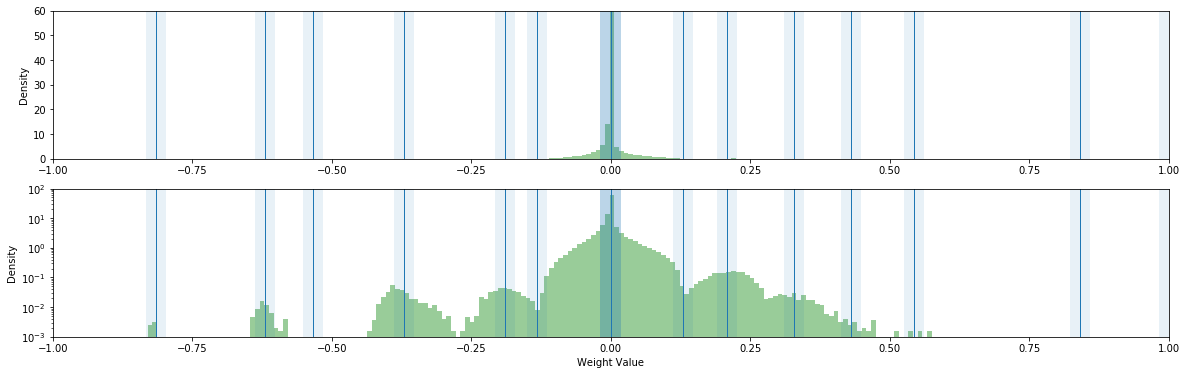

Original: 98.26% - Retrain: 94.84% - Prune: 84.53% - Quantize: 87.49% - Sparsity: 91.71%
Epoch: 20. Loss: -1.14


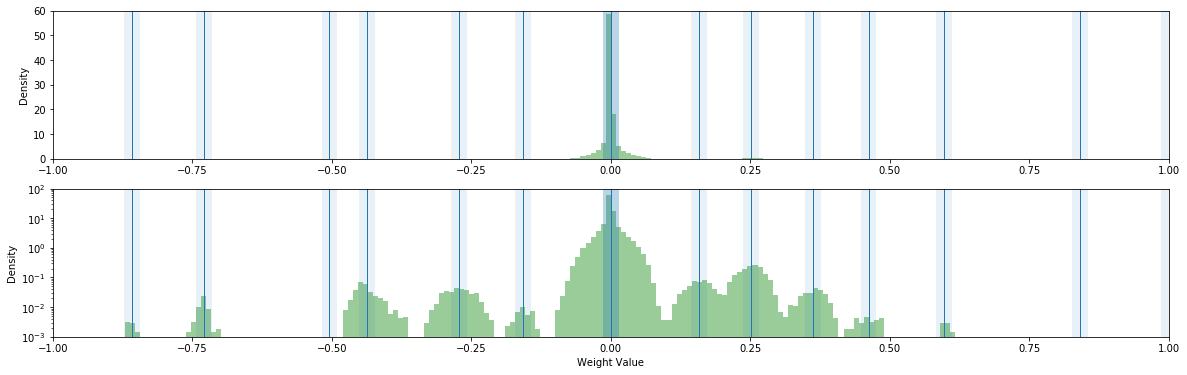

Original: 98.26% - Retrain: 93.21% - Prune: 64.43% - Quantize: 64.21% - Sparsity: 97.16%
Epoch: 30. Loss: -1.23


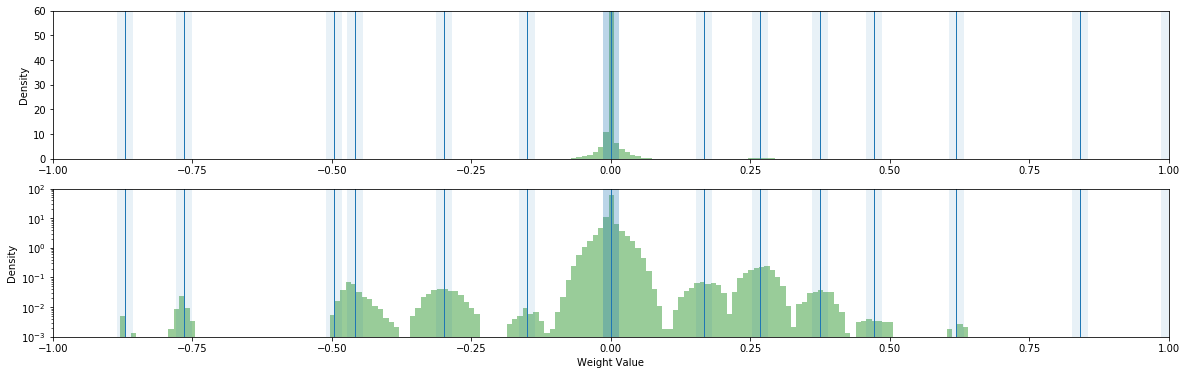

Original: 98.26% - Retrain: 93.19% - Prune: 64.59% - Quantize: 65.01% - Sparsity: 97.15%
Epoch: 40. Loss: -1.23


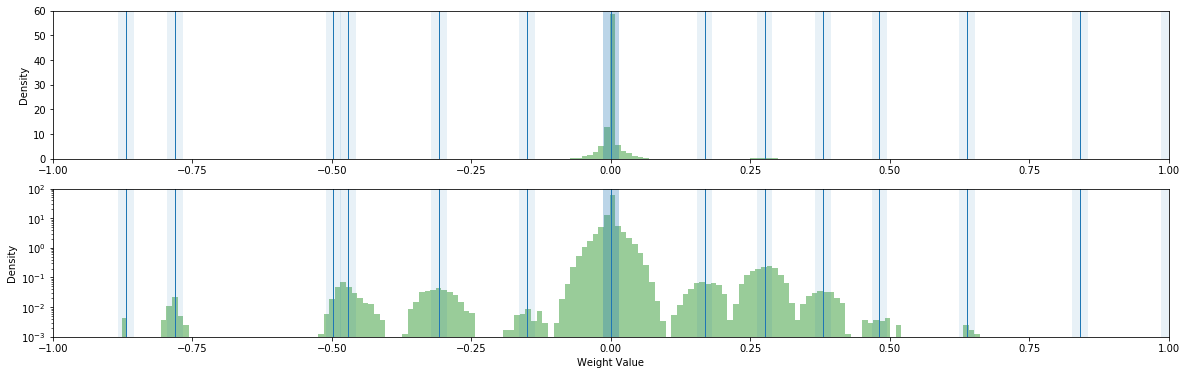

Original: 98.26% - Retrain: 93.84% - Prune: 64.04% - Quantize: 64.34% - Sparsity: 97.16%
Epoch: 50. Loss: -1.18


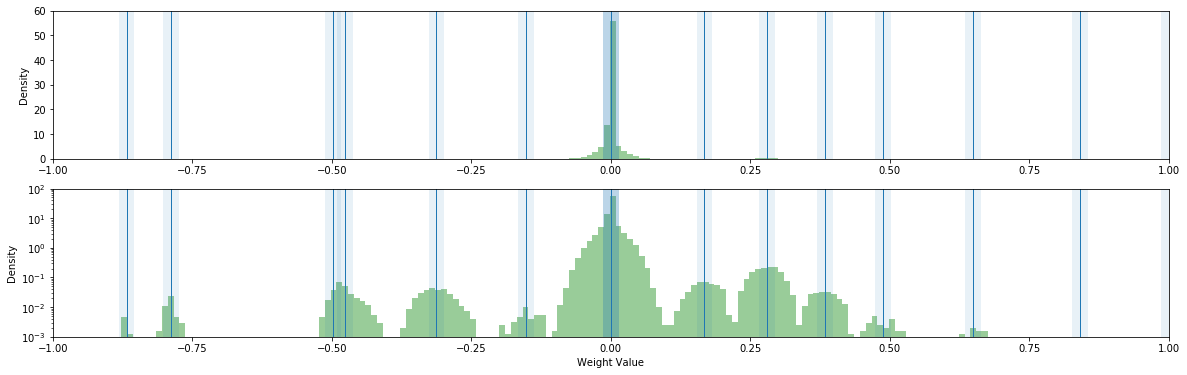

Original: 98.26% - Retrain: 93.21% - Prune: 64.08% - Quantize: 64.43% - Sparsity: 97.16%
Original: 98.26% - Retrain: 93.21% - Prune: 64.08% - Quantize: 64.43% - Sparsity: 97.16%
93.21|64.08_64.43|97.16


In [16]:
layer_model, gmp, res = layer_exp(5000, 2, 5000, 10, 15, 1, 1e-9, 1, 'CESH')
print (res)

In [22]:
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
full_model = torch.load(model_load_dir + model_file + ".m")
layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)

Original: 98.26% - Retrain: 97.24% - Prune: 95.52% - Quantize: 94.95% - Sparsity: 97.40%


(97.24, 95.52, 94.95, 97.40382165605097)

In [6]:
data_size = 'search'
model_name = 'LeNet_300_100'
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)

test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()

(x_start, x_end) = (40000, 50000)
images = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
targets = (get_targets(model_file, 0, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()
targets = nn.ReLU()(targets)
targets = nn.Softmax(dim=1)(targets/temp)

forward = layer_model(test_data_full)
outputs = nn.LogSoftmax(dim=1)((nn.ReLU()(forward))/temp)
loss_soft_target = -torch.mean(torch.sum(targets * outputs, dim=1))